Model Accuracy: 47.01%


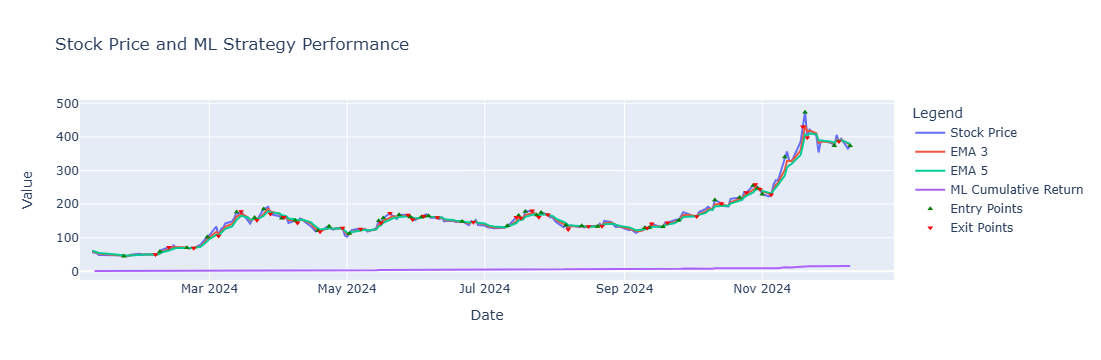

Initial Investment: $57.73
Final Value: $933.99
Total Return: $876.27
Average Win: 6.75%
Average Loss: -3.48%


In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def fetch_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df['Date'] = df.index
    df.reset_index(drop=True, inplace=True)
    return df

def calculate_features(df):
    df['Returns'] = df['Close'].pct_change()
    df['EMA_3'] = df['Close'].ewm(span=3, adjust=False).mean()
    df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
    df['Volatility'] = df['Returns'].rolling(window=5).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['Signal'] = (df['Returns'].shift(-1) > 0).astype(int)  # Buy if next day's return is positive
    df.dropna(inplace=True)
    return df

def train_ml_model(df):
    features = ['Volatility', 'EMA_3', 'EMA_5', 'Momentum']
    X = df[features]
    y = df['Signal']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=32)
    
    model = RandomForestClassifier(n_estimators=2, random_state=32)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Model Accuracy: {accuracy:.2%}")
    
    return model

def generate_signals_using_ml(df, model):
    features = ['Volatility', 'EMA_3', 'EMA_5', 'Momentum']
    df['ML_Signal'] = model.predict(df[features])
    df['ML_Position'] = df['ML_Signal'].shift()
    df['ML_Strategy_Return'] = df['Returns'] * df['ML_Position']
    df['ML_Cumulative_Return'] = (1 + df['ML_Strategy_Return']).cumprod()
    
    # Calculate individual trade returns
    df['Trade_Return'] = df['ML_Strategy_Return']
    df['Trade_Return'] = df['Trade_Return'].where(df['ML_Position'] == 1)
    
    # Mark trades
    df['Trade'] = df['ML_Position'].diff().fillna(0)
    df['Trade'] = df['Trade'].replace({1: 'Entry', -1: 'Exit'})
    
    return df

def plot_results(df):
    fig = go.Figure()

    # Plot stock price
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Stock Price'))

    # Plot EMAs
    fig.add_trace(go.Scatter(x=df['Date'], y=df['EMA_3'], mode='lines', name='EMA 3'))
    fig.add_trace(go.Scatter(x=df['Date'], y=df['EMA_5'], mode='lines', name='EMA 5'))

    # Plot cumulative return from ML strategy
    fig.add_trace(go.Scatter(x=df['Date'], y=df['ML_Cumulative_Return'], mode='lines', name='ML Cumulative Return'))

    # Plot entry points
    entry_points = df[df['Trade'] == 'Entry']
    fig.add_trace(go.Scatter(
        x=entry_points['Date'], 
        y=entry_points['Close'],
        mode='markers',
        marker=dict(symbol='triangle-up', color='green', size=5),
        name='Entry Points'
    ))

    # Plot exit points
    exit_points = df[df['Trade'] == 'Exit']
    fig.add_trace(go.Scatter(
        x=exit_points['Date'], 
        y=exit_points['Close'],
        mode='markers',
        marker=dict(symbol='triangle-down', color='red', size=5),
        name='Exit Points'
    ))

    fig.update_layout(title='Stock Price and ML Strategy Performance',
                      xaxis_title='Date',
                      yaxis_title='Value',
                      legend_title='Legend')

    fig.show()

def display_numerical_results(df):
    # Total return in dollar amount
    initial_investment = df['Close'].iloc[0]  # Initial stock price
    final_value = df['ML_Cumulative_Return'].iloc[-1] * initial_investment
    total_return_dollars = final_value - initial_investment
    
    # Calculate individual trade returns
    trades = df[df['Trade'].notna()]
    trade_returns = trades['Trade_Return'].dropna()
    
    # Average win and loss
    wins = trade_returns[trade_returns > 0]
    losses = trade_returns[trade_returns < 0]
    
    average_win = wins.mean() if not wins.empty else 0
    average_loss = losses.mean() if not losses.empty else 0
    
    print(f"Initial Investment: ${initial_investment:.2f}")
    print(f"Final Value: ${final_value:.2f}")
    print(f"Total Return: ${total_return_dollars:.2f}")
    print(f"Average Win: {average_win:.2%}")
    print(f"Average Loss: {average_loss:.2%}")

# Example usage
start_date = '2024-01-01'
end_date = '2024-12-30'
df = fetch_stock_data('MSTR', start_date, end_date)
df = calculate_features(df)
model = train_ml_model(df)
df = generate_signals_using_ml(df, model)
plot_results(df)
display_numerical_results(df)
